# Identification
Please indicate your name and parcours (e.g.: IMA, DIGIT, BIM, DAC, ..., Erasmus)

Student 1: Defne Gülmez (DIGIT)

Student 2: Yalda Efekhari (DIGIT)

# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [2]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercise 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [3]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    #defning the filters
    S_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    S_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    #convolve with the filters 
    I_x = convolve2d(I, S_x, mode = 'same')
    I_y = convolve2d(I, S_y, mode = 'same')

    #gradient norm
    grad_norm = np.sqrt(I_x**2 + I_y**2)

    #tresholding the norm
    n, m = grad_norm.shape
    tres_norm = np.zeros_like(grad_norm)
    for i in range(n):
        for j in range(m):
            if grad_norm[i, j] >= s:
                tres_norm[i, j] = grad_norm[i, j]
            else:
                tres_norm[i, j] = 0 

    
    return tres_norm



2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [4]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    #filter and convolution
    L = np.array([[0,1,0], [1,-4,1], [0,1,0]])
    laplacian = convolve2d(I, L, mode='same')

    n, m = laplacian.shape
    crossing = np.zeros_like(laplacian)

    for i in range(1, n-1):
        for j in range(1, m-1):
            #finding the 3 by 3 neighbors
            neighborrow = laplacian[i-1:i+2, j-1:j+2]
            min_val = np.min(neighborrow)
            max_val = np.max(neighborrow)

            if max_val >0 and min_val<0 and (max_val - min_val) > s:
                crossing[i, j] = 1
    return crossing 


    


3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

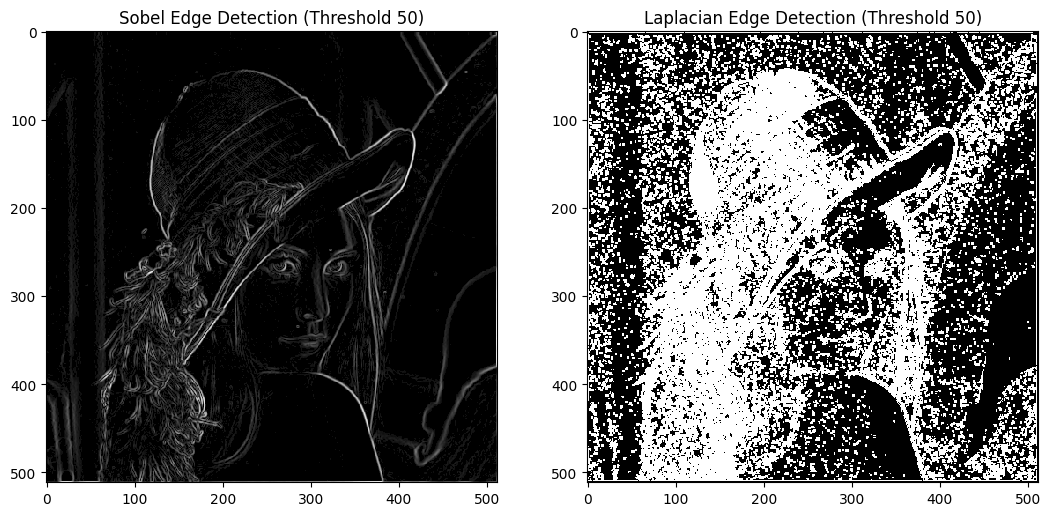

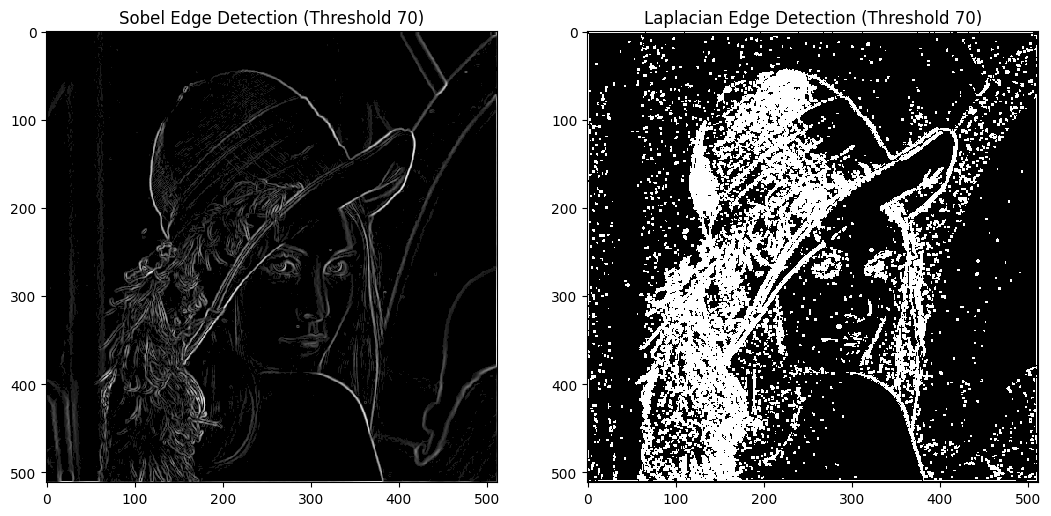

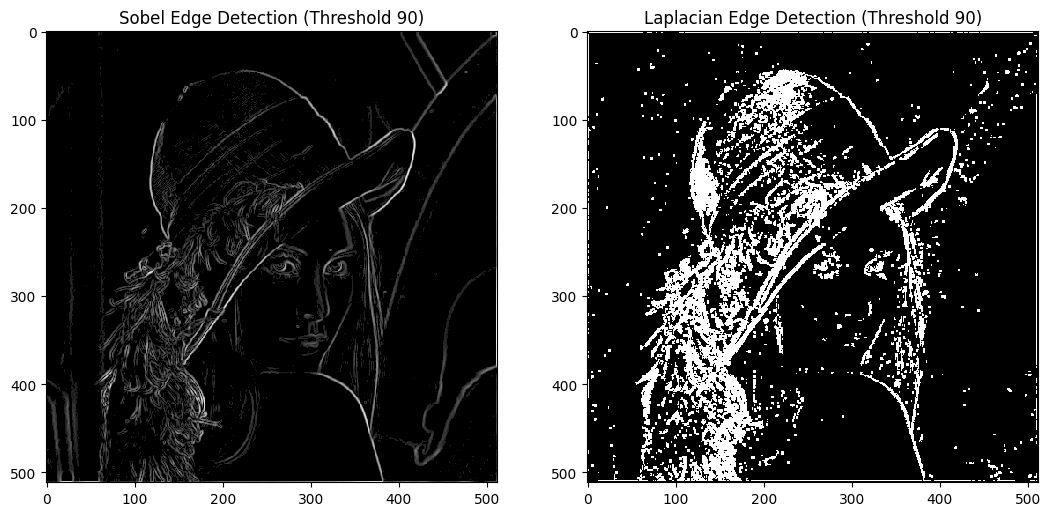

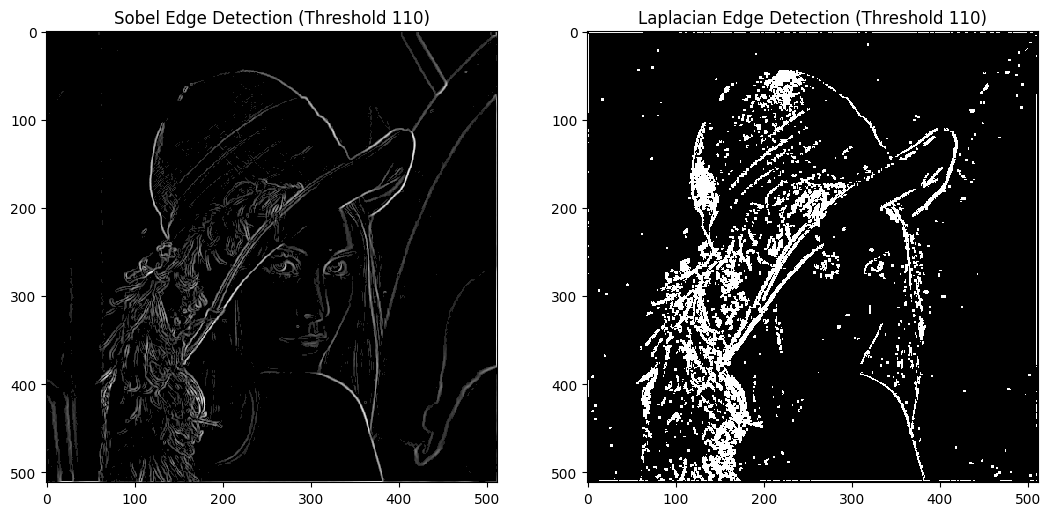

In [5]:

#load the image
I = np.array(Image.open('img/lena.png').convert('L'))

#apply the sobel and laplacian detector with different values of resholds

for t in [50, 70, 90, 110]:
    Sobel = SobelDetector(I, t)
    Laplacian = LaplacianDetector(I, t)

    niceDisplay14([Sobel, Laplacian], 
                  [f"Sobel Edge Detection (Threshold {t})", 
                   f"Laplacian Edge Detection (Threshold {t})"])
    
#an example where almost the same edges are given could be (50, 90)

## Exercise 2: non maximum suppression

This exercise addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the notebook to see pixels value pointed by the mouse screen. **Warning**, this mode works only with jupyter notebook up to version 6).

In [6]:
#!pip install notebook==6 ipywidgets ipympl

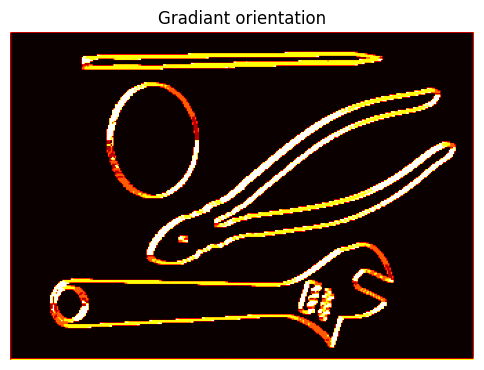

In [7]:
#### your answer below

#load the image
I = np.array(Image.open('img/tools.png').convert('L'))

#defning the filters
S_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
S_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

#convolve with the filters 
I_x = convolve2d(I, S_x, mode = 'same')
I_y = convolve2d(I, S_y, mode = 'same')

I_g = np.sqrt(I_x **2 + I_y **2)

orian = orientation(I_x, I_y, I_g) 

'''NOTE: This did not work in Jupyter Notebook. As a result, I used 'widget' in VS code and got the results accordingly. To do this I need to
download 'ipympl' like I did above and switch to widget GUI by running '%matplotlib widget' right before the following code.
'''
imshow_hot(orian, title ="Gradiant orientation", size = 500)

Explain the different values given to a pixel by `orientation()`:

Your answer: There are different values given to a pixel which is represented as colors within the outputted graph. These are as follows:

black --> 0 (no edge detected, intensity is almost constant, which means no significant change in the brigtenss or texture)

red --> 1 (vertical edge detected, the intensity changes in the horizantal direction)

orange --> 2 (gradiant is diagonal, there is an edge from the left-top to bottom-right or vice versa)

yellow --> 3 (horizantal edge is deceted, meaning the intensity change in the vertical direction.)

white --> 4 (gradiant is diagonal, there is an edge from the right-top to bottom-left or vice versa)

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [8]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    n,m = Ig.shape
    G = np.zeros((n, m)) #output
    
    #finding the local maxima gradient norm in the direction of the gradient
    for i in range(1, n-1):
        for j in range(1, m-1): #excluding the edges 
            direction = Ior[i,j]


            if direction == 1: #horizantal grad so check right and left
                if Ig[i,j] >= Ig[i, j+1] and Ig[i,j] >= Ig[i, j-1]:
                    G[i,j] = Ig[i, j]
            elif direction == 2: #diagonal from left top to bottom right, so check top left corner and right bottoom corner
                if Ig[i,j] >= Ig[i-1, j-1] and Ig[i,j] >= Ig[i+1, j+1]:
                    G[i,j] = Ig[i, j]
            elif direction == 3: #vertical gradient check top and bottom
                if Ig[i,j] >= Ig[i-1, j] and Ig[i,j] >= Ig[i+1, j]:
                    G[i,j] = Ig[i, j]
            elif direction == 4: #diagonal grad from top right to bottom left, so check the top left corner and bottom left corner
                if Ig[i,j] >= Ig[i-1, j+1] and Ig[i,j] >= Ig[i+1, j-1]:
                    G[i,j] = Ig[i, j]
            #If direction = 0, just leave it as 0 since no edge is detected.
    return G

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


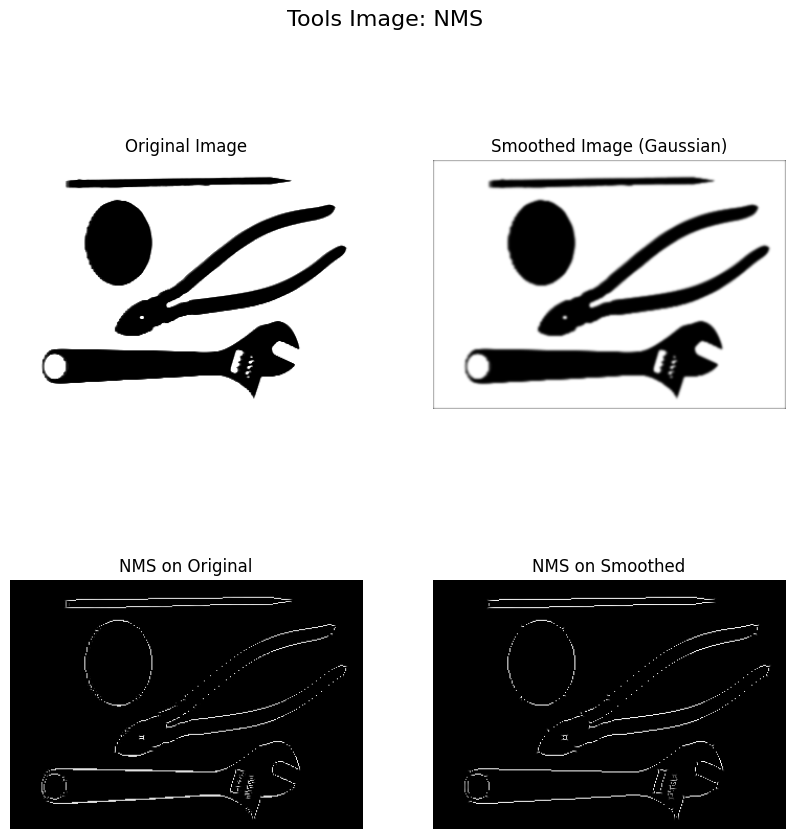

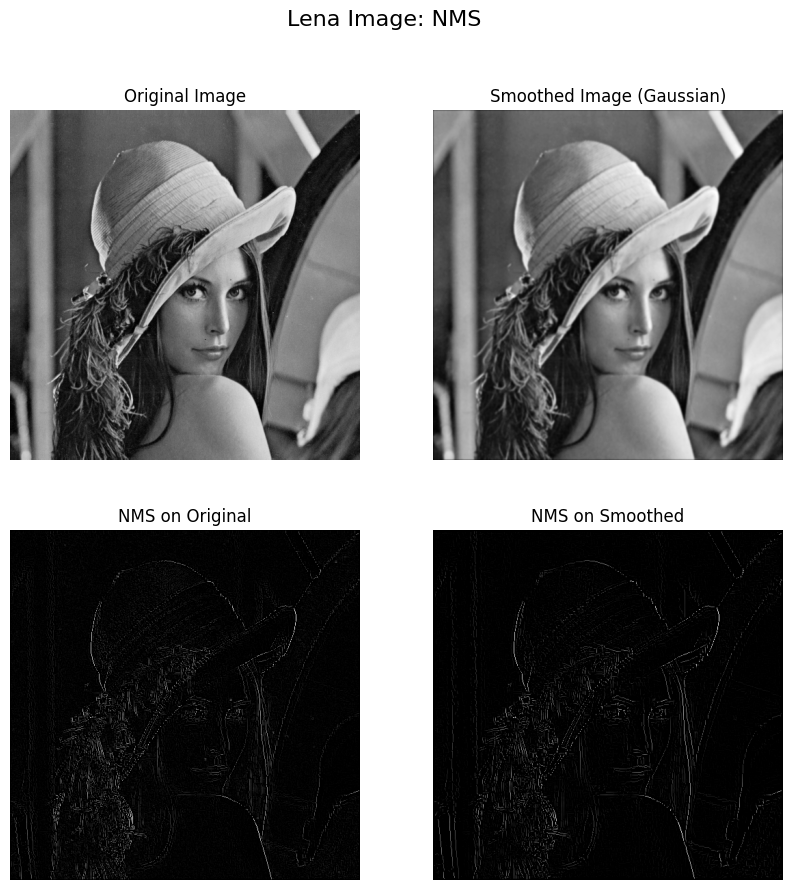

In [9]:
%matplotlib inline
### your answer below

#load the images
tools = np.array(Image.open('img/tools.png').convert('L'))
lena = np.array(Image.open('img/lena.png').convert('L'))

#gaussian filter
gaussian_filter = gaussianKernel(1.0)
tools_smoothed = convolve2d(tools, gaussian_filter, mode='same')
lena_smoothed = convolve2d(lena, gaussian_filter, mode='same')

#creating a new function to apply sobel to make thing easier

def apply_sobel(I):
    Sx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])  # Sobel x-direction
    Sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])  # Sobel y-direction
    Ix = convolve2d(I, Sx, mode='same')
    Iy = convolve2d(I, Sy, mode='same')
    Ig = np.sqrt(Ix**2 + Iy**2)  # Gradient norm
    Ior = orientation(Ix, Iy, Ig)  # Gradient orientation
    return Ig, Ior

#orientations and gradients
tools_ig, tools_ior = apply_sobel(tools)
lena_ig, lena_ior = apply_sobel(lena)
lena_smooth_ig, lena_smooth_ior = apply_sobel(lena_smoothed)
tools_smooth_ig, tools_smooth_ior = apply_sobel(tools_smoothed)

#applying the nms
tools_nms = nms(tools_ig, tools_ior)
tools_smoothed_nms = nms(tools_smooth_ig, tools_smooth_ior)
lena_nms = nms(lena_ig, lena_ior)
lena_smoothed_nms = nms(lena_smooth_ig, lena_smooth_ior)


# Visualize
def display_results(original, smoothed, nms, smoothed_nms, title):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)

    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original Image')

    axes[0, 1].imshow(smoothed, cmap='gray')
    axes[0, 1].set_title('Smoothed Image (Gaussian)')

    axes[1, 0].imshow(nms, cmap='gray')
    axes[1, 0].set_title('NMS on Original')

    axes[1, 1].imshow(smoothed_nms, cmap='gray')
    axes[1, 1].set_title('NMS on Smoothed')

    for ax in axes.flatten():
        ax.axis('off')

    plt.show()

display_results(tools, tools_smoothed, tools_nms, tools_smoothed_nms, 'Tools Image: NMS')
display_results(lena, lena_smoothed, lena_nms, lena_smoothed_nms, 'Lena Image: NMS')



4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

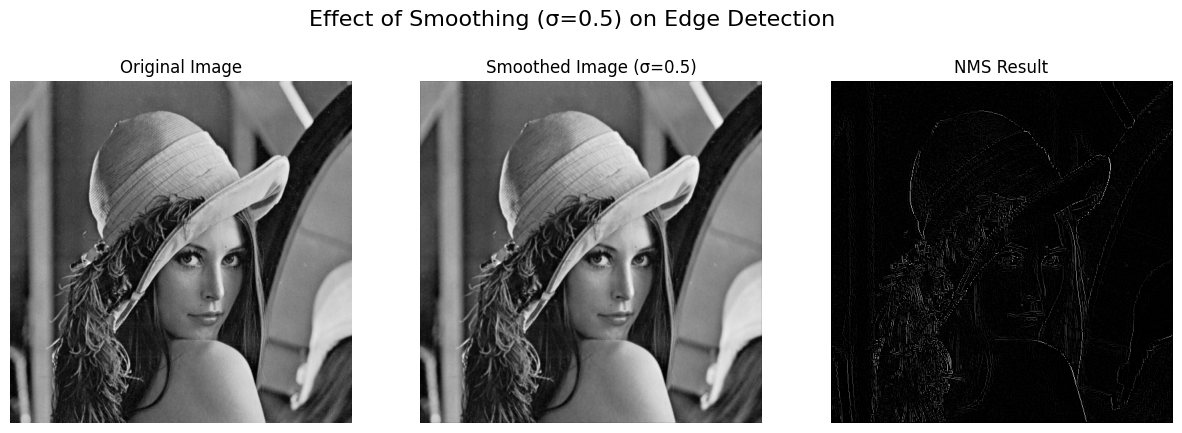

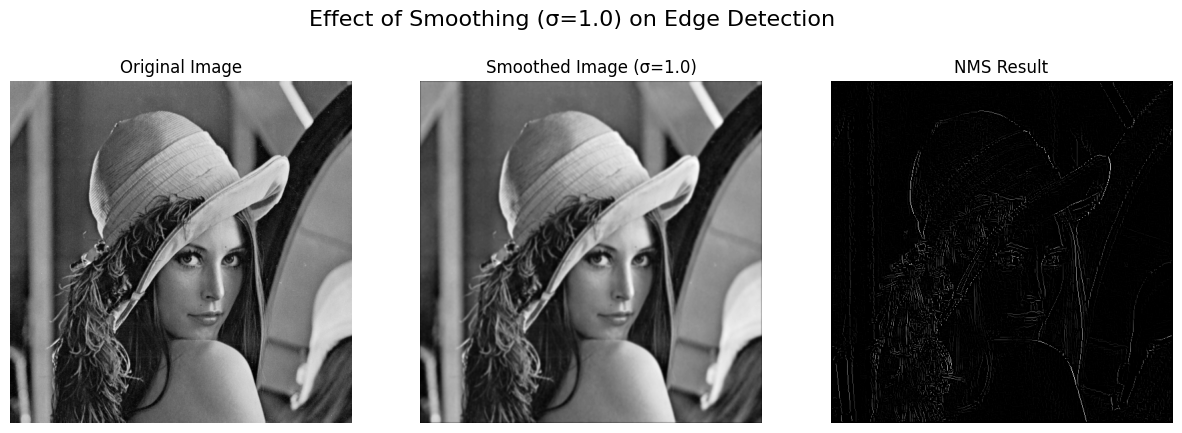

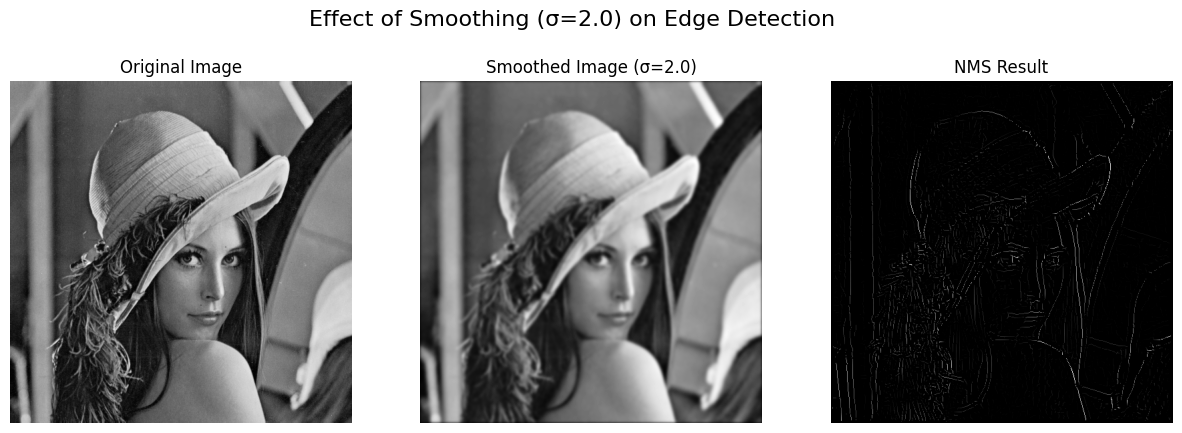

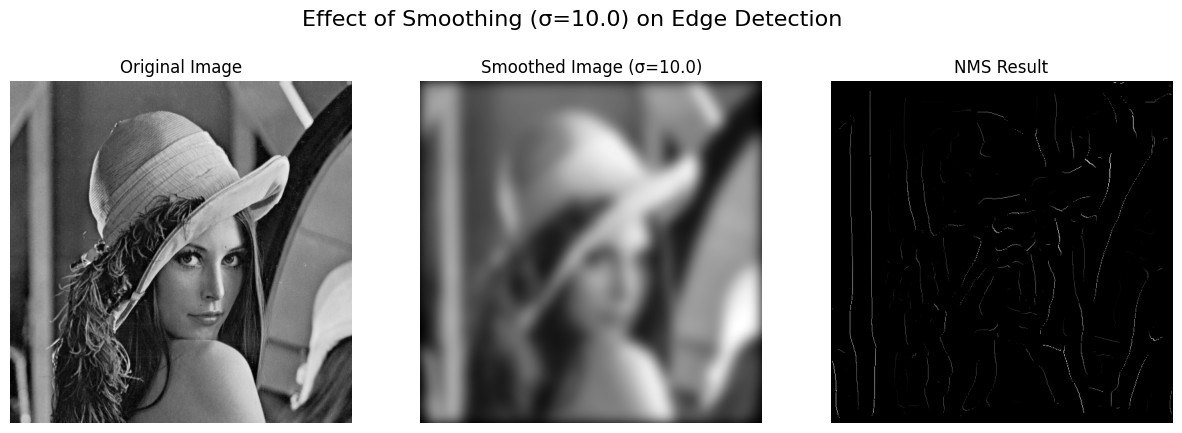

'\nWith small sigma values, there are small intensity changes such as noise, which is still detected as edges. But with huge sigma values the \nthe image becomes over-smoothed, which causes some existing edges to be undetected. \nAlso, with small sigma, the edges detected are thinner and sharper; with bigger sigma values, the edges become thicker. \n'

In [10]:
def display_results(original, smoothed, nms_result, sigma):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Effect of Smoothing (σ={sigma}) on Edge Detection', fontsize=16)

    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')

    axes[1].imshow(smoothed, cmap='gray')
    axes[1].set_title(f'Smoothed Image (σ={sigma})')

    axes[2].imshow(nms_result, cmap='gray')
    axes[2].set_title('NMS Result')

    for ax in axes:
        ax.axis('off')

    plt.show()


# experimentiong with different values of sigma
sigma_values = [0.5, 1.0, 2.0, 10.0]

for sigma in sigma_values:
    gaussian_filter = gaussianKernel(sigma)
    lena_smoothed = convolve2d(lena, gaussian_filter, mode='same')
    lena_smoothed_ig, lena_smoothed_ior = apply_sobel(lena_smoothed)
    lena_smoothed_nms = nms(lena_smoothed_ig, lena_smoothed_ior)
    display_results(lena, lena_smoothed, lena_smoothed_nms, sigma)


"""
With small sigma values, there are small intensity changes such as noise, which is still detected as edges. But with huge sigma values the 
the image becomes over-smoothed, which causes some existing edges to be undetected. 
Also, with small sigma, the edges detected are thinner and sharper; with bigger sigma values, the edges become thicker. 
"""

## Exercise 3:  effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

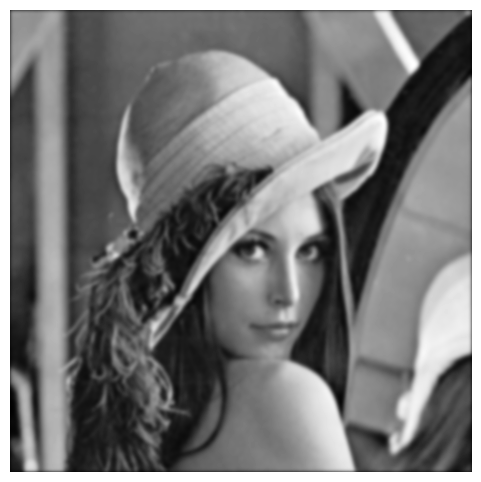

In [11]:
gaussian_filter = gaussianKernel(2.0)
lena_smoothed = convolve2d(lena, gaussian_filter, mode='same')
imshow(lena_smoothed)

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

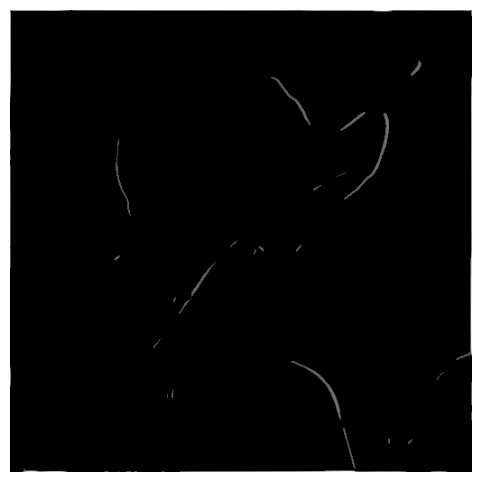

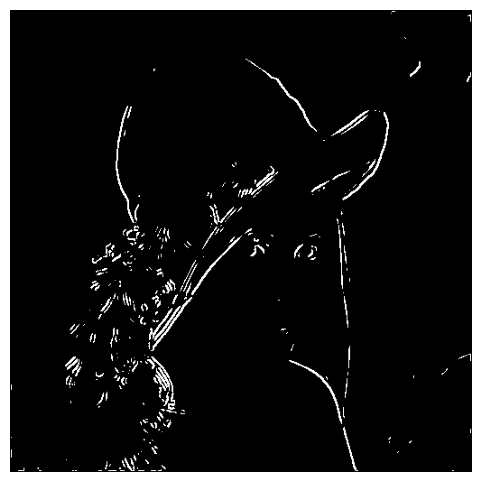

In [12]:
sobel_detected = SobelDetector(lena_smoothed, 200)
laplacian_detected = LaplacianDetector(lena_smoothed, 10)

imshow(sobel_detected)
imshow(laplacian_detected)

#After smoothing, It is seen that the Sobel detector gives thicker lines and doesn't see the details, while the laplacian detector gives thiner
#edges and can detect many more edges more precisely. 

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

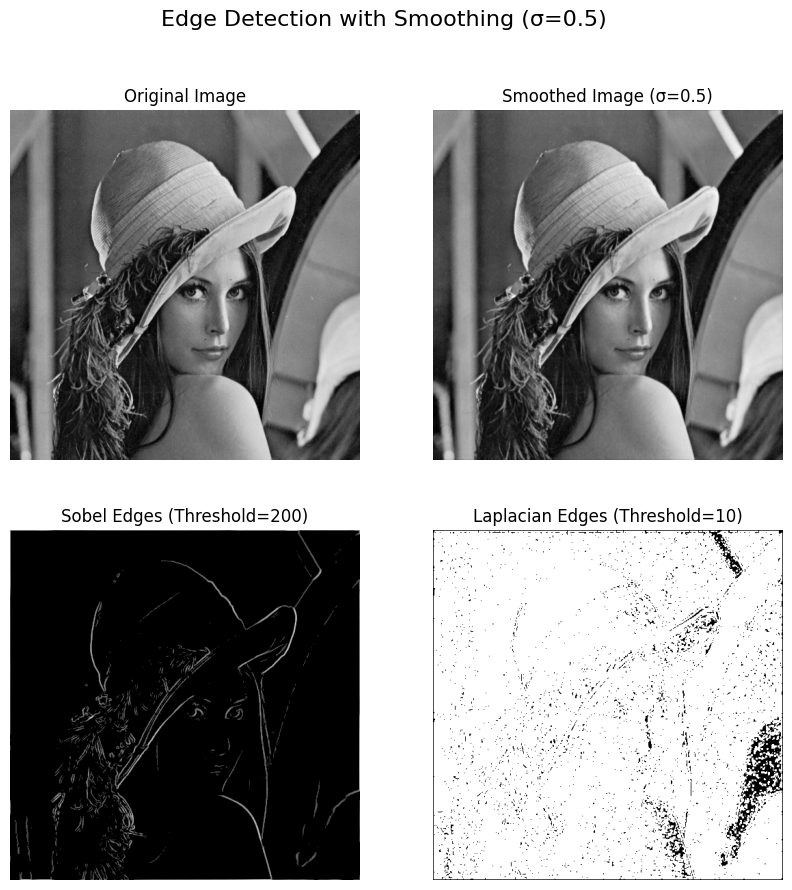

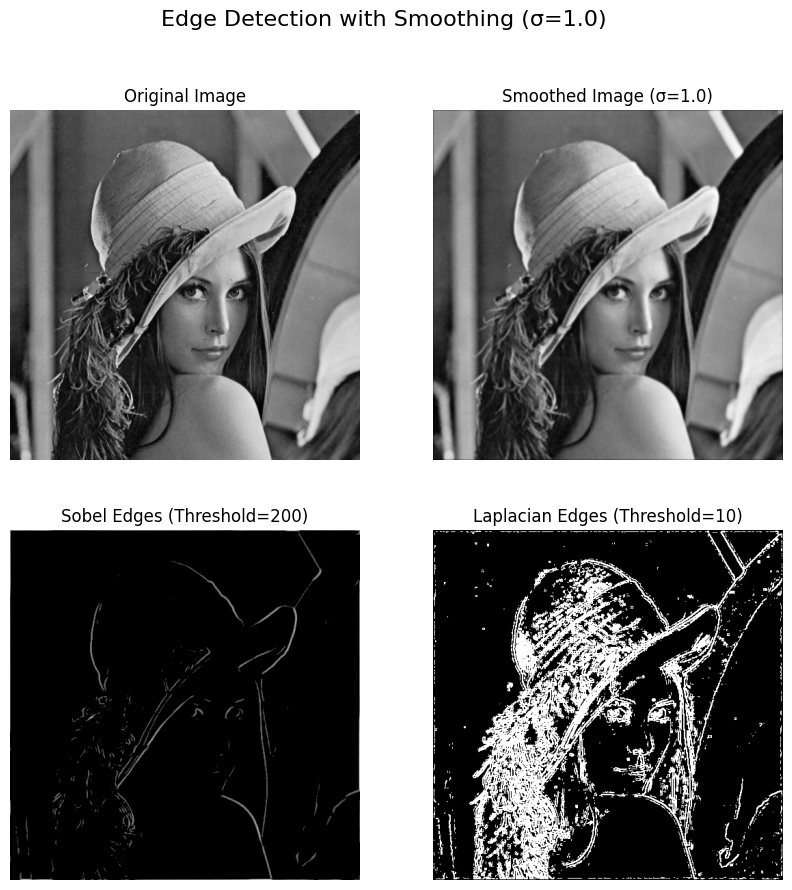

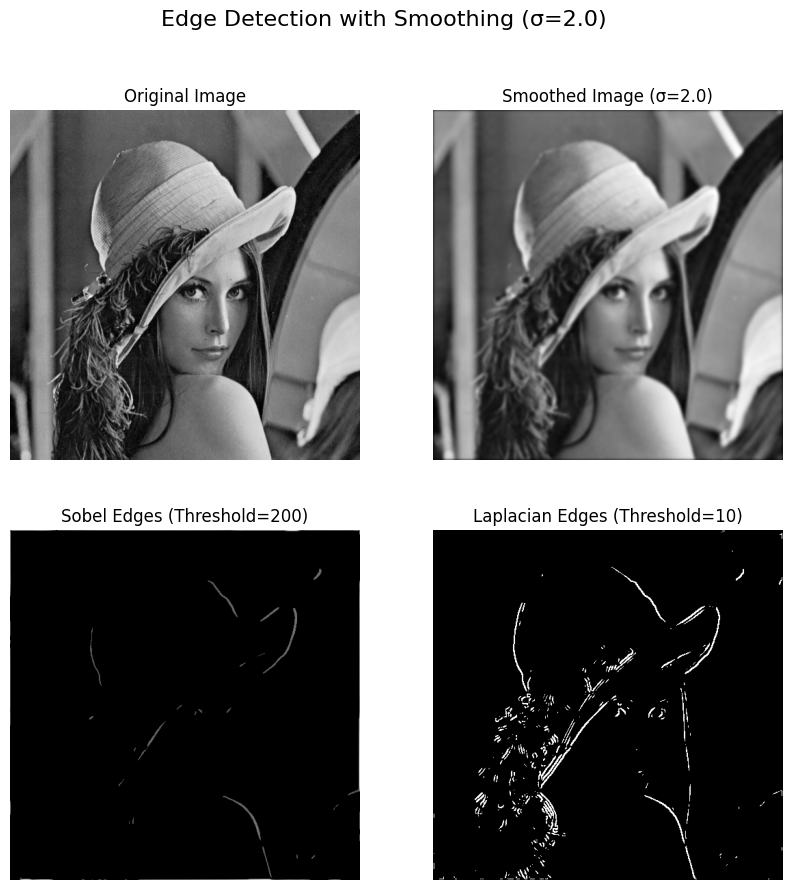

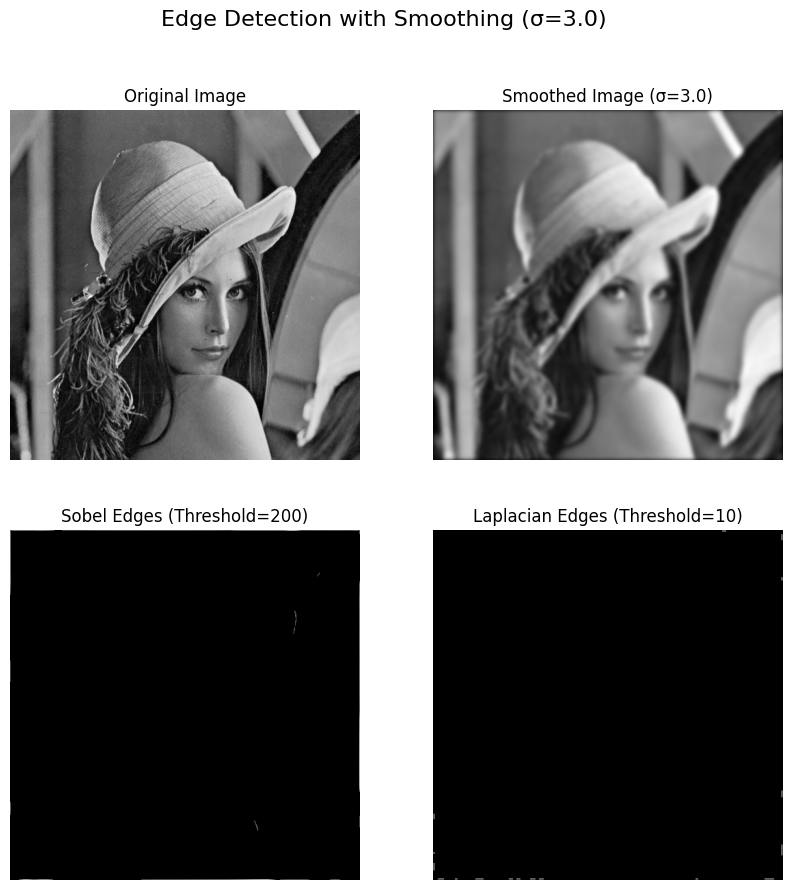

'\nSmoothing with small values of sigma gives thinner edges and shows more details where the contours are localized accurately but it also \ncontains noise which can be detected as an edge by accident. On the other hand, smoothing with big sigma values causes thicker lines and \nthe details to disappear with less precisely localized contours. This causes most of the edges not to be detected due to oversmoothing.\n'

In [13]:
def display_comparison(original, smoothed, sobel_edges, laplacian_edges, sigma):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f'Edge Detection with Smoothing (σ={sigma})', fontsize=16)

    axes[0,0].imshow(original, cmap='gray')
    axes[0,0].set_title('Original Image')

    axes[0,1].imshow(smoothed, cmap='gray')
    axes[0,1].set_title(f'Smoothed Image (σ={sigma})')

    axes[1,0].imshow(sobel_edges, cmap='gray')
    axes[1,0].set_title(f'Sobel Edges (Threshold=200)')

    axes[1,1].imshow(laplacian_edges, cmap='gray')
    axes[1,1].set_title(f'Laplacian Edges (Threshold=10)')

    for ax in axes.flatten():
        ax.axis('off')

    plt.show()

sigma_values = [0.5, 1.0, 2.0, 3.0] #sigma_1 = 0.5, sigma_2 = 3

for sigma in sigma_values:
    gaussian_filter = gaussianKernel(sigma)
    lena_smoothed = convolve2d(lena, gaussian_filter, mode='same')
    
    sobel_edges = SobelDetector(lena_smoothed, 200)  # Threshold = 200
    laplacian_edges = LaplacianDetector(lena_smoothed, 10)  # Threshold = 10
    
    display_comparison(lena, lena_smoothed, sobel_edges, laplacian_edges, sigma)

"""
Smoothing with small values of sigma gives thinner edges and shows more details where the contours are localized accurately but it also 
contains noise which can be detected as an edge by accident. On the other hand, smoothing with big sigma values causes thicker lines and 
the details to disappear with less precisely localized contours. This causes most of the edges not to be detected due to oversmoothing.
"""

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

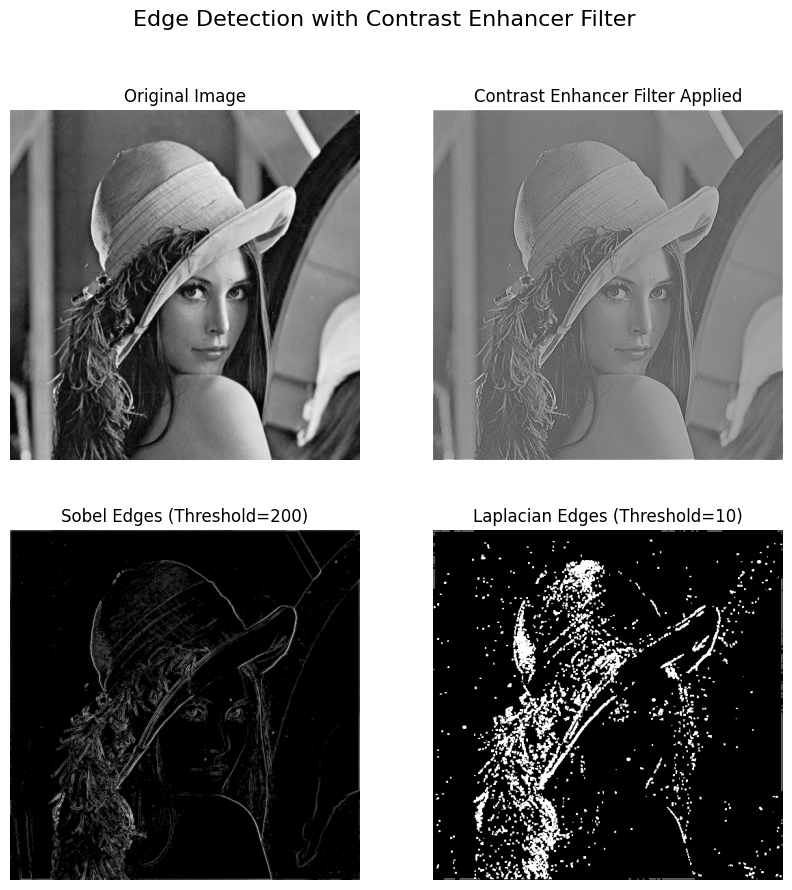

'\nWith the contrast enhancer filter, more edges can be detected as it enhances small differences in intensity. However, this could also result \nin the enhancement of noise and causes some noise to be falsely detected as images which can also be seen in the results below.\n'

In [14]:
lena = np.array(Image.open('img/lena.png'))
#constrast enhancer filter
contrast_filter = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])

#apply the filter than the detectors
lena_contrast = convolve2d(lena, contrast_filter, mode='same')
contrast_sobel = SobelDetector(lena_contrast, 200) 
contrast_laplacian = LaplacianDetector(lena_contrast, 600) #threshold 10 was too low, just showing an all-white image

#results
def display_results(original, enhanced, contrast_sobel, contrast_laplacian, filter_name):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f'Edge Detection with {filter_name} Filter', fontsize=16)

    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original Image')

    axes[0, 1].imshow(enhanced, cmap='gray')
    axes[0, 1].set_title(f'{filter_name} Filter Applied')

    axes[1, 0].imshow(contrast_sobel, cmap='gray')
    axes[1, 0].set_title('Sobel Edges (Threshold=200)')

    axes[1, 1].imshow(contrast_laplacian, cmap='gray')
    axes[1, 1].set_title('Laplacian Edges (Threshold=10)')

    for ax in axes.flatten():
        ax.axis('off')

    plt.show()

display_results(lena, lena_contrast, contrast_sobel, contrast_laplacian, 'Contrast Enhancer')

"""
With the contrast enhancer filter, more edges can be detected as it enhances small differences in intensity. However, this could also result 
in the enhancement of noise and causes some noise to be falsely detected as images which can also be seen in the results below.
"""

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

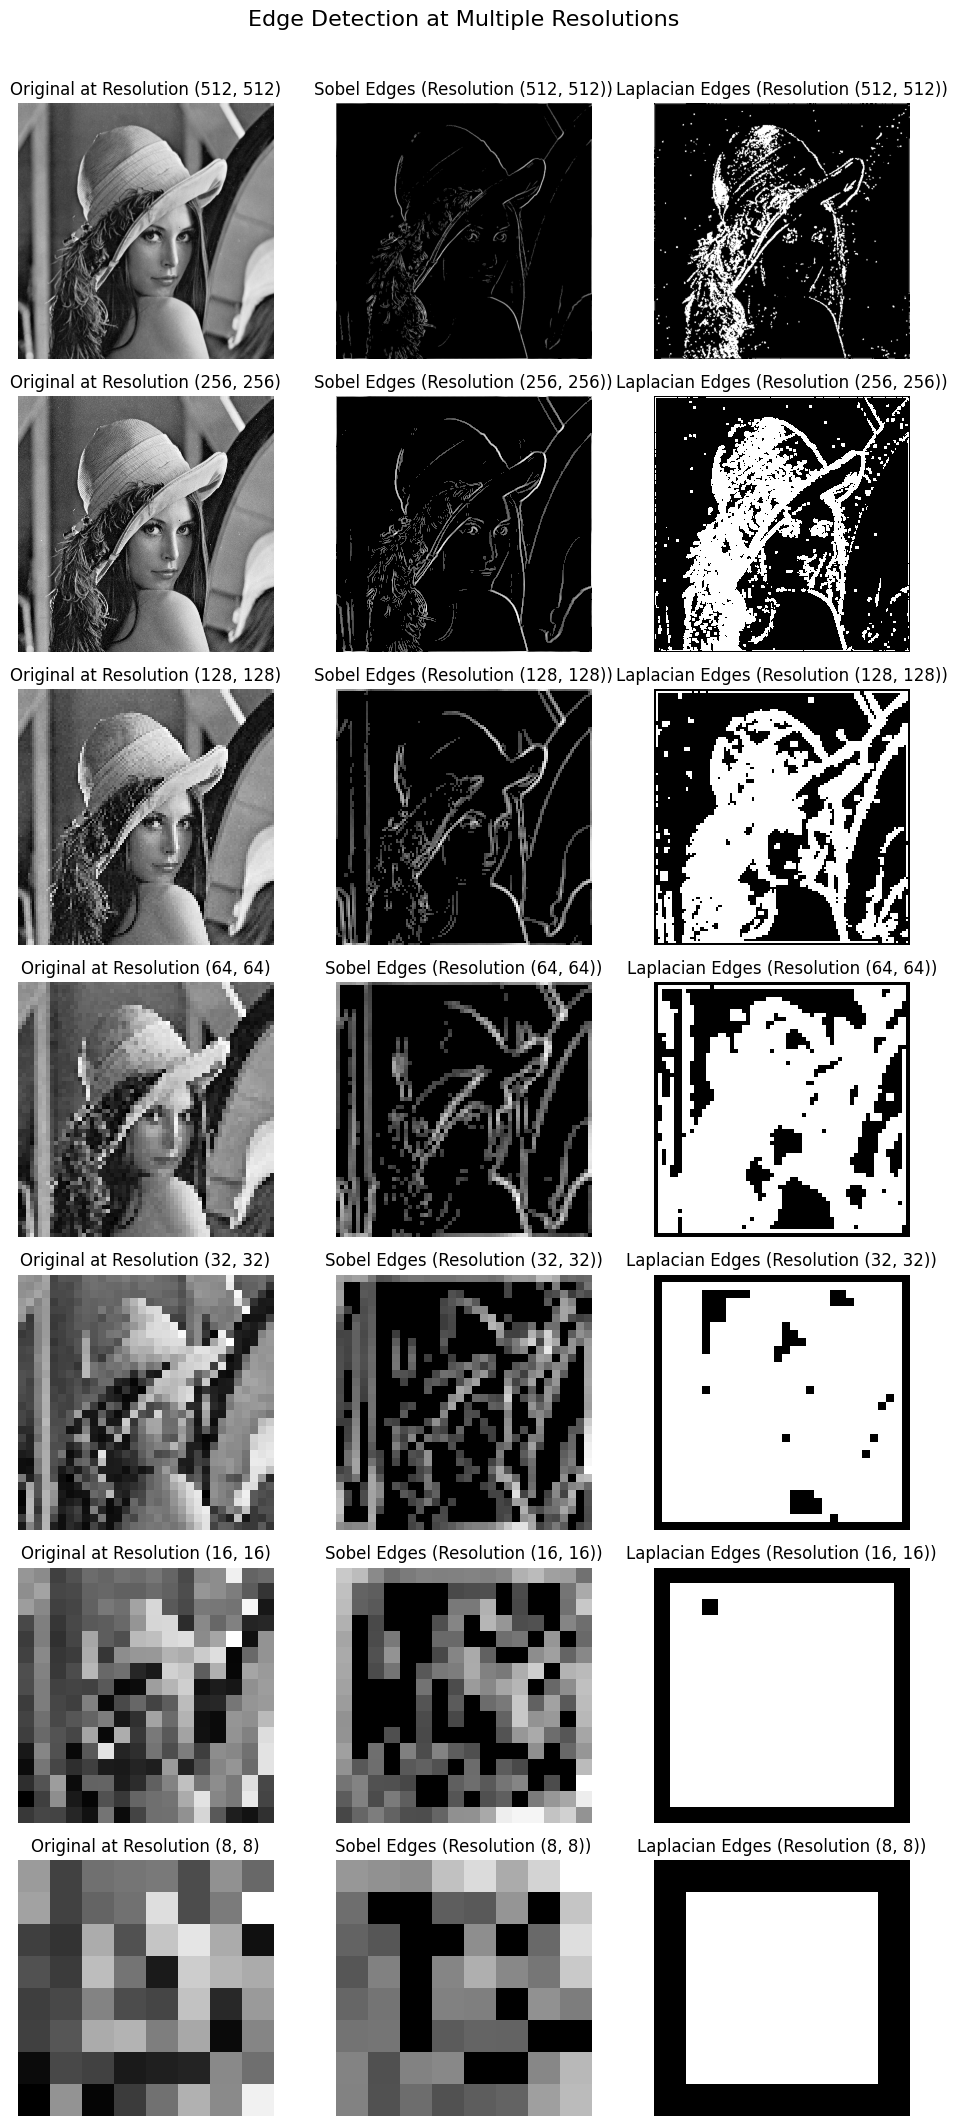

'\nIn higher resolutions, close to the original image, both detectors can pick up small edges along with the noise. \nHowever, as the image is decomposed further, the details get lost and the edges start to be not detected which is an expected outcome. \nWe see that for both detectors, edges become thick lines as the details get lost.\n'

In [15]:
'''
applying the multiresolution down to min_size, returning a list of progressively downsampled images.
down_image --> contains the list of downsampled images
'''
def multiresolution(image, min_size):
    down_image = [image]
    while down_image[-1].shape[0]> min_size and down_image[-1].shape[1]>min_size:
        downsampled = down_image[-1][::2, ::2]
        down_image.append(downsampled)
    return down_image

#apply both detectors to each resolution
def apply_detectors(down_image, sobel_treshold= 200, laplacian_treshold= 100):
    sobel_res = []
    laplacian_res = []
    for image in down_image:
        sobel_res1 = SobelDetector(image, sobel_treshold)
        laplacian_res1 = LaplacianDetector(image, laplacian_treshold)
        sobel_res.append(sobel_res1)
        laplacian_res.append(laplacian_res1)
    return sobel_res, laplacian_res

#to make displaying the results look better and easier
def display_results(down_image, sobel_res, laplacian_res):
    num_levels = len(down_image)
    fig, axes = plt.subplots(num_levels, 3, figsize=(10, num_levels * 3))
    fig.suptitle('Edge Detection at Multiple Resolutions', fontsize=16, y = 1.01)
    for i in range(num_levels):
        axes[i, 0].imshow(down_image[i], cmap='gray')
        axes[i, 0].set_title(f'Original at Resolution {down_image[i].shape}')
        axes[i, 1].imshow(sobel_res[i], cmap='gray')
        axes[i, 1].set_title(f'Sobel Edges (Resolution {down_image[i].shape})')
        axes[i, 2].imshow(laplacian_res[i], cmap='gray')
        axes[i, 2].set_title(f'Laplacian Edges (Resolution {down_image[i].shape})')
        
        for ax in axes[i, :]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

min_size = 8
down_image = multiresolution(lena, min_size)
sobel_res, laplacian_res = apply_detectors(down_image)
display_results(down_image, sobel_res, laplacian_res)

"""
In higher resolutions, close to the original image, both detectors can pick up small edges along with the noise. 
However, as the image is decomposed further, the details get lost and the edges start to be not detected which is an expected outcome. 
We see that for both detectors, edges become thick lines as the details get lost.
"""